![](../assets/images/construction.gif)

# Journey 4
## Part 1


### Transfer Learning 

This is simply where we train a network for one task and then use some or all of that learning in a different task.

In [1]:
from os import listdir
from os.path import isdir, isfile, join
import re
import numpy as np
from PIL import Image
import random
import re

In [2]:
DATA_DIR = '../data/fruits-360-data/fruits-360'
TEST_DATA = DATA_DIR + '/Test'
TRAIN_DATA = DATA_DIR + '/Training'

In [3]:
#
# Create a one-hot encoding for the given list
#
def create_one_hot_encoding_dicts(list_to_encode):
    list_to_one_hot = dict()
    one_hot_to_item = dict()
    for i, l in enumerate(list_to_encode):
        oh = np.zeros((len(list_to_encode)))
        oh[i] = 1
        list_to_one_hot[l] = oh
        one_hot_to_item[np.array2string(oh)] = l
    return list_to_one_hot, one_hot_to_item

In [4]:
#
# Return a list of only the JPG files for a given dir
#
def list_files(data_dir):
    jpg_files = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and re.search('\.jpg$',f,flags=re.IGNORECASE)]
    return jpg_files

In [5]:
#
# Load a given list of fruits from the selected data set location
#
def load_data(fruits_to_get, 
              test_data_dir,
              train_data_dir
             ):
    
    one_hot_dict, item_dict = create_one_hot_encoding_dicts(fruits_to_get)
        
    test_data = []
    train_data = []
    
    for fruit in fruits_to_get:
        
        test_fruit_dir = test_data_dir + "/" + fruit
        train_fruit_dir = train_data_dir + "/" + fruit
        
        if isdir(test_fruit_dir) and isdir(train_fruit_dir):
            one_hot_val = one_hot_dict[fruit]
            
            print("loading [" + fruit + "]" + " one hot: " + str(one_hot_val))
            
            print('Test Data')
            for img_file in list_files(test_fruit_dir):
                test_data.append([np.array(Image.open(join(test_fruit_dir,img_file))), one_hot_val])
                print('.', end='')
            print('')

            print('Training Data')
            for img_file in list_files(train_fruit_dir):
                train_data.append([np.array(Image.open(join(train_fruit_dir,img_file))), one_hot_val])
                print('.', end='')
            print('')

            img_shape = test_data[0][0].shape
            one_hot_shape = test_data[0][1].shape
            
            # Convert data to numpy
            x_test = np.zeros((len(test_data), *img_shape))
            y_test = np.zeros((len(test_data), one_hot_shape[0]))
            x_train = np.zeros((len(train_data), *img_shape))
            y_train = np.zeros((len(train_data), one_hot_shape[0]))
            
            i = 0 
            rnd_idx = random.sample(range(0, len(test_data)), len(test_data))
            for img, one_hot in test_data:
                x_test[rnd_idx[i]] = img / 255.0  # rescale 0.0 to 1.0
                y_test[rnd_idx[i]] = one_hot
                i += 1

            i = 0 
            rnd_idx = random.sample(range(0, len(train_data)), len(train_data))
            for img, one_hot in train_data:
                x_train[rnd_idx[i]] = img / 255.0  # rescale 0.0 to 1.0
                y_train[rnd_idx[i]] = one_hot
                i += 1

        else:
            raise Exception("Cannot load unknown fruit - missing from test and/or train data set[" + fruit + "]")
            
    return x_train, \
           y_train, \
           x_test, \
           y_test, \
           one_hot_dict, \
           item_dict
        

In [6]:
list_to_get = ["Apple Golden 1",
               "Apple Golden 2",
               "Apple Golden 3",
               "Apple Red 1",
               "Apple Red 2",
               "Apple Red 3"]              
x_train, y_train, x_test, y_test, _, item_dict = load_data(list_to_get, TEST_DATA, TRAIN_DATA)

loading [Apple Golden 1] one hot: [1. 0. 0. 0. 0. 0.]
Test Data
....................................................................................................................................................................
Training Data
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
loading [Apple Golden 2] one hot: [0. 1. 0. 0. 0. 0.]
Test Data
....................................................................................................................................................................
Training Data
.....................

In [7]:
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)
        

(961, 100, 100, 3)
(961, 6)
(2878, 100, 100, 3)
(2878, 6)


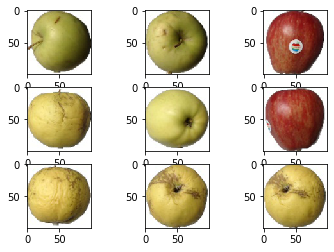

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], interpolation='none')

In [9]:
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.losses import categorical_crossentropy
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17004226011686571945
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4944779673
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 2236497245262049967
physical_device_desc: "device: 0, name: GeForce GTX TITAN Z, pci bus id: 0000:04:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 4944779673
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 17802197083239996548
physical_device_desc: "device: 1, name: GeForce GTX TITAN Z, pci bus id: 0000:05:00.0, compute capability: 3.5"
]


In [89]:
def build_cnn_layers(model_name,
                     input_shape):
    cnn_in = Input(shape=input_shape_cnn, name = model_name+"_cnn0Input")
    cnn_l1 = Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', name = model_name+"_cnn1_Conv2d")(cnn_in) 
    cnn_l2 = MaxPooling2D(pool_size=(2, 2), name = model_name+"_cnn2_MaxPool2D")(cnn_l1)
    cnn_l3 = BatchNormalization(name = model_name+"_cnn3_BatchNorm")(cnn_l2) 
    cnn_l4 = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', name = model_name+"_cnn3_conv2d")(cnn_l3)
    cnn_l5 = MaxPooling2D(pool_size=(2, 2), name = model_name+"_cnn5_MaxPool2D")(cnn_l4)
    cnn_l6 = BatchNormalization(name = model_name+"_cnn6_BatchNorm")(cnn_l5) 
    cnn_l7 = Dropout(rate=0.25,name = model_name+"_cnn7_Dropout")(cnn_l6) 
    cnn_out = Flatten(name = model_name+"_cnnOutput_Flatten")(cnn_l7)
    return cnn_in, cnn_out

In [90]:
def build_classifier_layers(model_name,
                            num_classes,
                            input_layer):
    cl_l1 = Dense(500, activation='relu', name = model_name+"_clInput_Dense")(input_layer)
    cl_l2 = Dropout(rate=0.25, name = model_name+"_cl1_Dropout")(cl_l1)
    cl_out = Dense(num_classes, activation='softmax', name = model_name+"_clOutput")(cl_l2)
    return cl_out

In [91]:
input_shape = (100, 100, 3)
num_classes = 6
model_name = "classifier_" + str(num_classes)

model_cnn_in, model_cnn_out = build_cnn_layers(model_name, input_shape)
model_cl_out = build_classifier_layers(model_name, num_classes, model_cnn_out)

model = Model(inputs=[model_cnn_in],outputs=[model_cl_out])
model.name = model_name

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_6_cnn0Input (Inpu (None, 100, 100, 3)       0         
_________________________________________________________________
classifier_6_cnn1_Conv2d (Co (None, 96, 96, 16)        1216      
_________________________________________________________________
classifier_6_cnn2_MaxPool2D  (None, 48, 48, 16)        0         
_________________________________________________________________
classifier_6_cnn3_BatchNorm  (None, 48, 48, 16)        64        
_________________________________________________________________
classifier_6_cnn3_conv2d (Co (None, 23, 23, 32)        4640      
_________________________________________________________________
classifier_6_cnn5_MaxPool2D  (None, 11, 11, 32)        0         
_________________________________________________________________
classifier_6_cnn6_BatchNorm  (None, 11, 11, 32)        128       
__________

In [92]:
model = multi_gpu_model(model, gpus=2)

In [93]:
# Compile Model
model.compile(loss=categorical_crossentropy,
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

In [94]:
batch_size = 32
num_epochs = 3
history = model.fit(x_train, y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, y_test)
                    )

Train on 2878 samples, validate on 961 samples
Epoch 1/3
2878/2878 [==============================] - 4s 1ms/step - loss: 0.2932 - acc: 0.9138 - val_loss: 0.0687 - val_acc: 0.9688
Epoch 2/3
2878/2878 [==============================] - 2s 820us/step - loss: 0.0331 - acc: 0.9910 - val_loss: 0.0485 - val_acc: 0.9761
Epoch 3/3
2878/2878 [==============================] - 2s 817us/step - loss: 0.0200 - acc: 0.9958 - val_loss: 0.0224 - val_acc: 1.0000


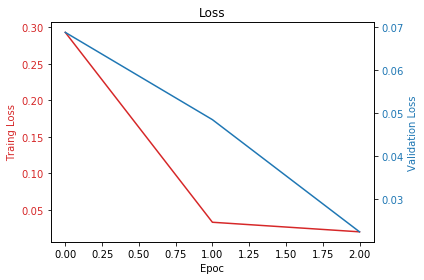

In [95]:
epocs = np.arange(0,num_epochs,1)

fig, ax1 = plt.subplots()
plt.title('Loss')

color = 'tab:red'
ax1.set_xlabel('Epoc')
ax1.set_ylabel('Traing Loss', color=color)
ax1.plot(epocs, history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(epocs, history.history['val_loss'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

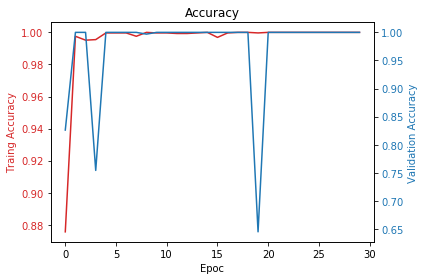

In [16]:
epocs = np.arange(0,num_epochs,1)

fig, ax1 = plt.subplots()
plt.title('Accuracy')

color = 'tab:red'
ax1.set_xlabel('Epoc')
ax1.set_ylabel('Traing Accuracy', color=color)
ax1.plot(epocs, history.history['acc'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(epocs, history.history['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
list_to_get = ["Apple Braeburn"]              
x1_train, y1_train, x1_test, y1_test, _, item_dict = load_data(list_to_get, TEST_DATA, TRAIN_DATA)

In [17]:
cnn_weights = model.get_weights()

In [18]:
for i, w in enumerate(cnn_weights):
    print(str(i) + ' : ' + str(w.shape))

0 : (5, 5, 3, 16)
1 : (16,)
2 : (16,)
3 : (16,)
4 : (3, 3, 16, 32)
5 : (32,)
6 : (32,)
7 : (32,)
8 : (3872, 500)
9 : (500,)
10 : (500, 6)
11 : (6,)
12 : (16,)
13 : (16,)
14 : (32,)
15 : (32,)


In [84]:
# Model strcuture changes when complied for GPU, so we need to look in diffent places for the 'actual' layers
def aij_model_summary(model):
    try:
        layers = model.get_layer(model_name).layers
    except:
        layers = model.layers
    
    for l in layers:
        print(l.name+":: params #"+str(l.count_params()))
        print(l.get_weights())
    return

In [85]:
aij_model_summary(model)

classifier_6_cnn0Input:: params #0
[]
classifier_6_cnn1_Conv2d:: params #1216
[array([[[[-0.09199151, -0.01735975,  0.01278748, ..., -0.06910731,
          -0.10412   , -0.01209252],
         [-0.11184264,  0.0636349 , -0.04890236, ..., -0.03967709,
          -0.05085579,  0.03631918],
         [ 0.07674201, -0.10300796,  0.10438503, ..., -0.01369945,
          -0.10446004, -0.025071  ]],

        [[ 0.09961246,  0.06938741, -0.03945168, ...,  0.11160624,
           0.04909424,  0.08591865],
         [ 0.04874451, -0.02998444, -0.00596625, ...,  0.0293237 ,
          -0.05203291, -0.07400611],
         [-0.06224243, -0.06168395, -0.07205652, ..., -0.00344724,
          -0.02539847, -0.02241167]],

        [[ 0.03939959,  0.11113916, -0.0182595 , ..., -0.10820072,
          -0.07696901,  0.05595236],
         [ 0.05039418, -0.08376685, -0.00964919, ...,  0.06140819,
          -0.02526819,  0.05230904],
         [ 0.05677852, -0.04833735,  0.06865676, ...,  0.04290584,
          -0.10164

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)]
classifier_6_cnn7_Dropout:: params #0
[]
classifier_6_cnnOutput_Flatten:: params #0
[]
classifier_6_clInput_Dense:: params #1936500
[array([[-0.0012675 , -0.01561551,  0.00178927, ..., -0.00097916,
        -0.022555  ,  0.03478304],
       [-0.01549225,  0.0226079 , -0.01591338, ...,  0.00514656,
        -0.02308573,  0.03440158],
      

## Articles of Interest

[gpu article 1](https://datascience.stackexchange.com/questions/23895/multi-gpu-in-keras)
[Keras Conv2D](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)

In [100]:
# Model strcuture changes when complied for GPU, so we need to look in diffent places for the 'actual' layers
def aij_save_cnn_layers(model):
    try:
        layers = model.get_layer(model_name).layers
    except:
        layers = model.layers
    
    for l in layers:
        l_name = l.name
        if re.search(".*cnn.*", l_name):
            w = l.get_weights()
            print('Saving Layer :'+ l.name + ":: params #"+str(l.count_params()))
            np.save(l_name + '.npy', w)
    return

In [101]:
aij_save_cnn_layers(model)

Saving Layer :classifier_6_cnn0Input:: params #0
Saving Layer :classifier_6_cnn1_Conv2d:: params #1216
Saving Layer :classifier_6_cnn2_MaxPool2D:: params #0
Saving Layer :classifier_6_cnn3_BatchNorm:: params #64
Saving Layer :classifier_6_cnn3_conv2d:: params #4640
Saving Layer :classifier_6_cnn5_MaxPool2D:: params #0
Saving Layer :classifier_6_cnn6_BatchNorm:: params #128
Saving Layer :classifier_6_cnn7_Dropout:: params #0
Saving Layer :classifier_6_cnnOutput_Flatten:: params #0
